# Regression models with large, sparse datasets
### by [Jason DeBacker](https://jasondebacker.com), January 2025

This notebook provides and overview of estimating OLS and Poisson regression models with large, sparse datasets.

In [1]:
# imports
import os
import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import linearmodels
import statsmodels.api as sm
import timeit

## Example data

Our example data are drawn from the trade data in the [Atlas of Economic Complexity](https://atlas.hks.harvard.edu).  The data are at the country-pair-product level and include the following variables, import and export values by year.  I've also added a few other variables to these data to make the regression models more interesting. These include measures of distance between the origin and destination countries and an indicator for whether the two countries share a common language.

Even this slimmed down dataset is still about 1.4GB when stored as a CSV file. Therefore, it doesn't reside in this repository.  You can download these data from my Dropbox by clicking this link.

In [39]:
# load the data
CUR_DIR = os.getcwd()
df = pd.read_csv(os.path.join(CUR_DIR, 'trade_data_small.csv'))


### Set up our data for estimation

Here, we clean our data for estimation.  We'll do the following:
1. Drop any rows with missing values for variables that will be included in the regression models.
2. Keep just the variables we'll use in the regression models.
3. Create dummy variables for the year of the data and for origin country.
4. Put these data in `X` and `y` DataFrames for ease of access in the estimation process.

In [40]:
# Clean data for regression
df.dropna(subset=['export_value', 'import_value', 'distw', 'year'], inplace=True)
df = df[['export_value', 'import_value', 'distw', 'year', 'iso_o']]
df0 = df.copy()
# make sparse by adding a bunch of FEs
df = pd.get_dummies(df, columns=['iso_o', 'year'], drop_first=True)
# Separate X and y for ease of use
y = df['export_value']
X = df.drop(columns='export_value')
# cast boolean columns to int
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype(int)

We are going to use the [`linearmodels`](https://bashtage.github.io/linearmodels/) library as well, which works with panel data.  For this model, we'll need to set up the data as a panel.  We'll do this by creating a `MultiIndex` for the data with the first level as the origin country and the second level as the year.  We'll then use the `PanelData` class from the `linearmodels` package to set up the data for estimation.

In [41]:
# linear models data setup
df_panel = pd.read_csv(os.path.join(CUR_DIR, 'trade_data_small.csv'))
# Clean data for regression
df_panel.dropna(subset=['export_value', 'import_value', 'distw', 'year'], inplace=True)
df_panel = df_panel[['export_value', 'import_value', 'distw', 'year', 'iso_o']]
# create multiindex with year and iso_0
df_panel = df_panel.set_index(['iso_o', 'year'])
X_panel = df_panel[['import_value', 'distw']]
y_panel = df_panel['export_value']

#### How sparse are these data?

In [5]:
# fraction of X that are non-zero
print('Fraction of X that are non-zero:', np.count_nonzero(X) / X.size)

Fraction of X that are non-zero: 0.050382865086549634


## Estimation of models with many FE

Now we'll compare how libraries, `linearmodels`, `statsmodels`, `sklearn`, handle estimation of models with many fixed effects.  We'll estimate the following models:

$$
exports = \beta_0 + \beta_1 \text{imports} + \beta_2 \text{distance} + \beta_3 \text{year dummies} + \beta_4 \text{origin country dummies} + \epsilon
$$

In [6]:

results_dict = {
    "library": ["statsmodels", "sklearn", "linearmodels"],
    "estimation time": [],
    "beta_1": [],
    "beta_2": []
}
for library in results_dict["library"]:
    if library == "statsmodels":
        model = sm.OLS(y, X)
        results = model.fit()
        # est_time = timeit.timeit('model.fit()', globals=globals(), number=10)
        # results_dict["estimation time"].append(est_time)
        results_dict["beta_1"].append(results.params['import_value'])
        results_dict["beta_2"].append(results.params['distw'])
    elif library == "sklearn":
        model = LinearRegression()
        model.fit(X, y)
        # est_time = timeit.timeit('model.fit(X, y)', globals=globals(), number=10)
        # results_dict["estimation time"].append(est_time)
        results_dict["beta_1"].append(model.coef_[0])
        results_dict["beta_2"].append(model.coef_[1])
    elif library == "linearmodels":
        model = linearmodels.PanelOLS(y_panel, X_panel, entity_effects=True, time_effects=True)
        results = model.fit()
        # est_time = timeit.timeit('model.fit()', globals=globals(), number=10)
        # results_dict["estimation time"].append(est_time)
        results_dict["beta_1"].append(results.params['import_value'])
        results_dict["beta_2"].append(results.params['distw'])
model = sm.OLS(y, X)
est_time1 = timeit.timeit('model.fit()', globals=globals(), number=10)
model = LinearRegression()
est_time2 = timeit.timeit('model.fit(X, y)', globals=globals(), number=10)
model = linearmodels.PanelOLS(y_panel, X_panel, entity_effects=True, time_effects=True)
est_time3 = timeit.timeit('model.fit()', globals=globals(), number=10)
results_dict["estimation time"] = [est_time1, est_time2, est_time3]


In [7]:
# Compare the results
results_df = pd.DataFrame(results_dict)
print(results_df)

        library  estimation time    beta_1      beta_2
0   statsmodels        16.613966  0.202560 -193.781718
1       sklearn        89.365360  0.202569 -193.160454
2  linearmodels       132.639871  0.202560 -193.892268


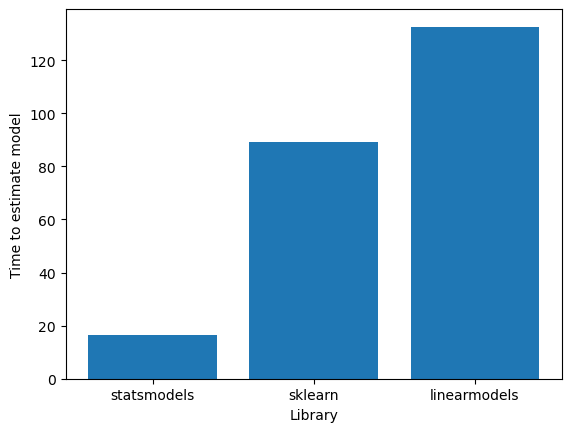

In [8]:
# Visualize the time to estimate the models
plt.bar(results_df['library'], results_df['estimation time'])
plt.ylabel('Time to estimate model')
plt.xlabel('Library')
plt.show()

## Estimation of models with many FE, but use sparse DataFrames

Now, we'll redo the above, but use spare DataFrames to store the data.  We'll see how this affects the estimation time.

First, we set up the data as sparse DataFrames.

In [9]:
# Make sparse DataFrame
sdf = df.astype(pd.SparseDtype("int", 0))
# Set up X and y for regression
y_sdf = df['export_value']
X_sdf = df.drop(columns='export_value')

In [10]:
# And do same for panel data
df_panel = pd.read_csv(os.path.join(CUR_DIR, 'trade_data_small.csv'))
# Clean data for regression
df_panel.dropna(subset=['export_value', 'import_value', 'distw', 'year'], inplace=True)
df_panel = df_panel[['export_value', 'import_value', 'distw', 'year', 'iso_o']]
# create multiindex with year and iso_0
df_panel = df_panel.set_index(['iso_o', 'year'])
# cast as sparse data
sdf_panel = df_panel.astype(pd.SparseDtype("int", 0))
X_sdfpanel = sdf_panel[['import_value', 'distw']]
y_sdfpanel = sdf_panel['export_value']

In [11]:
sparse_df_results_dict = {
    "library": ["sklearn", "linearmodels"], #["statsmodels", "sklearn", "linearmodels"],
    "estimation time": [],
    "beta_1": [],
    "beta_2": []
}
for library in sparse_df_results_dict["library"]:
    if library == "statsmodels":
        model = sm.OLS(y_sdf, X_sdf)
        results = model.fit()
        # est_time = timeit.timeit('model.fit()', globals=globals(), number=10)
        # sparse_df_results_dict["estimation time"].append(est_time)
        sparse_df_results_dict["beta_1"].append(results.params['import_value'])
        sparse_df_results_dict["beta_2"].append(results.params['distw'])
    elif library == "sklearn":
        model = LinearRegression()
        model.fit(X_sdf, y_sdf)
        # est_time = timeit.timeit('model.fit(X_sdf, y_sdf)', globals=globals(), number=10)
        # sparse_df_results_dict["estimation time"].append(est_time)
        sparse_df_results_dict["beta_1"].append(model.coef_[0])
        sparse_df_results_dict["beta_2"].append(model.coef_[1])
    elif library == "linearmodels":
        model = linearmodels.PanelOLS(y_sdfpanel, X_sdfpanel, entity_effects=True, time_effects=True)
        results = model.fit()
        # est_time = timeit.timeit('model.fit()', globals=globals(), number=10)
        # sparse_df_results_dict["estimation time"].append(est_time)
        sparse_df_results_dict["beta_1"].append(results.params['import_value'])
        sparse_df_results_dict["beta_2"].append(results.params['distw'])
# model = sm.OLS(y_sdf, X_sdf)
# est_time1 = timeit.timeit('model.fit()', globals=globals(), number=10)
model = LinearRegression()
est_time2 = timeit.timeit('model.fit(X_sdf, y_sdf)', globals=globals(), number=10)
model = linearmodels.PanelOLS(y_sdfpanel, X_sdfpanel, entity_effects=True, time_effects=True)
est_time3 = timeit.timeit('model.fit()', globals=globals(), number=10)
sparse_df_results_dict["estimation time"] = [est_time2, est_time3]

In [12]:
# Compare the results
sparse_df_results_df = pd.DataFrame(sparse_df_results_dict)
print(sparse_df_results_df)

        library  estimation time    beta_1      beta_2
0       sklearn        93.953737  0.202569 -193.160454
1  linearmodels       136.190419  0.202560 -193.895386


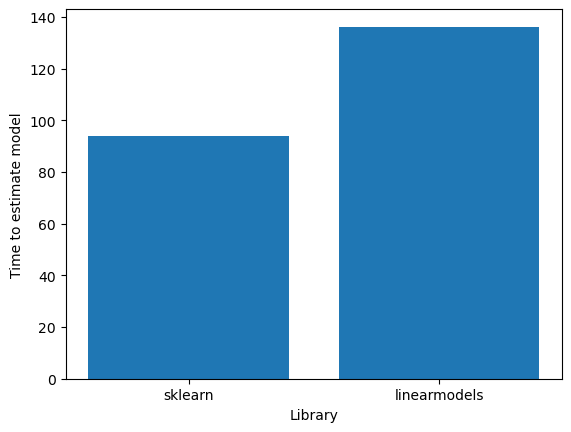

In [13]:
# Visualize the time to estimate the models
plt.bar(sparse_df_results_df['library'], sparse_df_results_df['estimation time'])
plt.ylabel('Time to estimate model')
plt.xlabel('Library')
plt.show()

## Estimating models with many FEs, but use SciPy sparse matrices

Now we do this one more time, using SciPy sparse matrices to store the data.  We'll see how this affects the estimation time.

Note that this means we cannot use the `linearmodels` package, as it requires the data to be in a `PanelData` object.  

In addition, `statsmodels` can't handle `scipy.sparse` objects.  We'll estimate this model with just Numpy arrays.

`sklearn` is the only one of these libraries that can handle sparse matrices.

In [14]:
# Create sparse matrix in CSR format
X_sparse = csr_matrix(X)
y_arr = y.values

In [15]:
sparse_results_dict = {
    "library": ["statsmodels", "sklearn"],
    "estimation time": [],
    "beta_1": [],
    "beta_2": []
}
for library in sparse_results_dict["library"]:
    if library == "statsmodels":
        model = sm.OLS(y_arr, X_sparse.toarray())
        results = model.fit()
        # est_time = timeit.timeit('model.fit()', globals=globals(), number=1)
        # print("Estimated time for statsmodels:", est_time)
        # sparse_results_dict["estimation time"].append(est_time)
        sparse_results_dict["beta_1"].append(results.params[0])
        sparse_results_dict["beta_2"].append(results.params[1])
    elif library == "sklearn":
        model = LinearRegression()
        model.fit(X_sparse, y_arr)
        # est_time = timeit.timeit('model.fit(X_sparse, y_arr)', globals=globals(), number=1)
        # print("Estimated time for sklearn:", est_time)
        # sparse_results_dict["estimation time"].append(est_time)
        sparse_results_dict["beta_1"].append(model.coef_[0])
        sparse_results_dict["beta_2"].append(model.coef_[1])
model = sm.OLS(y_arr, X_sparse.toarray())
est_time1  = timeit.timeit('model.fit()', globals=globals(), number=10)
model = LinearRegression()
model.fit(X_sparse, y_arr)
est_time2 = timeit.timeit('model.fit(X_sparse, y_arr)', globals=globals(), number=10)
sparse_results_dict["estimation time"] = [est_time1, est_time2]

In [16]:
# Compare the results
sparse_results_df = pd.DataFrame(sparse_results_dict)
print(sparse_results_df)

       library  estimation time    beta_1      beta_2
0  statsmodels        18.644245  0.202560 -193.781718
1      sklearn         4.899787  0.203448 -196.704758


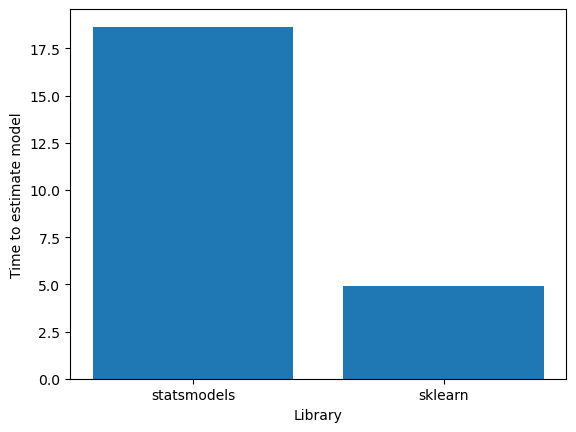

In [17]:
# Visualize the time to estimate the models
plt.bar(sparse_results_df['library'], sparse_results_df['estimation time'])
plt.ylabel('Time to estimate model')
plt.xlabel('Library')
plt.show()

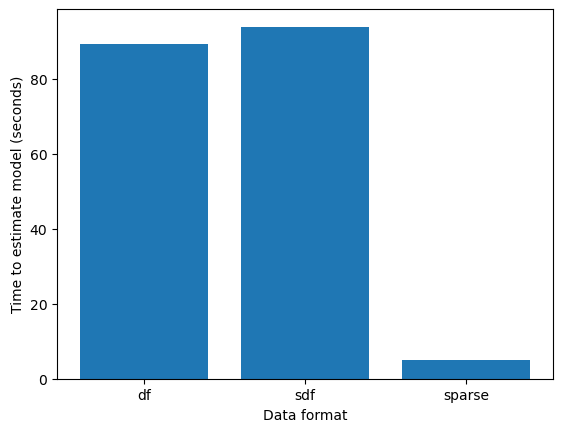

In [27]:
# Visualize the time to estimate sklearn models
data_format = ['df', 'sdf', 'sparse']
estimation_time = [
    results_dict["estimation time"][1],
    sparse_df_results_dict["estimation time"][0],
    sparse_results_dict["estimation time"][1],
]
plt.bar(data_format, estimation_time)
plt.ylabel('Time to estimate model (seconds)')
plt.xlabel('Data format')
plt.show()

In [19]:
# What about the memory footprint?
# Compare sizes of objects above
print("Size of X = ", X.memory_usage(index=True).sum()/1e6) # Pandas DataFrame
print("Size of X_sdf = ", X_sdf.memory_usage(index=True).sum()/1e6)  # Pandas sparse DataFrame
print("Size of X_sparse = ", X_sparse.data.nbytes/1e6)  # Scipy sparse object

Size of X =  3940.723584
Size of X_sdf =  636.262662
Size of X_sparse =  195.787376


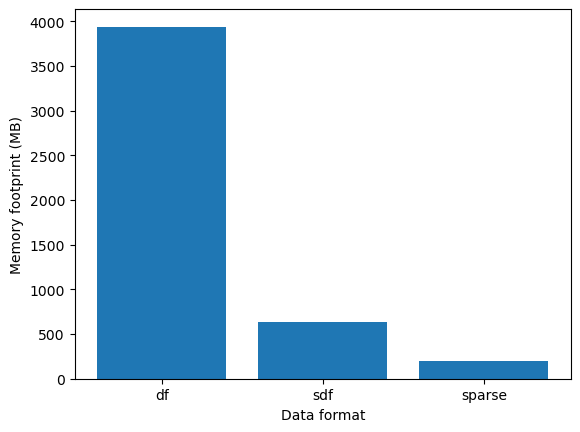

In [20]:
# Plot the memory footprint
data_format = ['df', 'sdf', 'sparse']
memory_footprint = [
    X.memory_usage(index=True).sum()/1e6,
    X_sdf.memory_usage(index=True).sum()/1e6,
    X_sparse.data.nbytes/1e6
]
plt.bar(data_format, memory_footprint)
plt.ylabel('Memory footprint (MB)')
plt.xlabel('Data format')
plt.show()

# Estimating Poisson models


In [21]:
from statsmodels.discrete.discrete_model import Poisson
res = Poisson(df["export_value"], df[["import_value", "distw"]]).fit(method='nm', maxiter=5000, disp=0)
print(res.summary())

/Users/jason.debacker/anaconda3/envs/usitc-env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


                          Poisson Regression Results                          
Dep. Variable:           export_value   No. Observations:              6841534
Model:                        Poisson   Df Residuals:                  6841532
Method:                           MLE   Df Model:                            1
Date:                Thu, 16 Jan 2025   Pseudo R-squ.:                  -3.021
Time:                        06:23:08   Log-Likelihood:            -1.7640e+14
converged:                       True   LL-Null:                   -4.3864e+13
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
import_value  9.105e-10   1.34e-16   6.78e+06      0.000    9.11e-10    9.11e-10
distw            0.0010   4.09e-11   2.35e+07      0.000       0.001       0.001


#### For Poisson with sparse matrices -- Use `sklearn`

In [60]:

from sklearn.linear_model import PoissonRegressor
model = PoissonRegressor(solver='newton-cholesky',max_iter=1000)
res = model.fit(df[["import_value", "distw"]].values, df["export_value"].values)
print(res.coef_)
print(res.intercept_)

/Users/jason.debacker/anaconda3/envs/usitc-env/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:576: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 2. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.01744e-20): result may not be accurate.
  warnings.warn(


[ 4.22474864e-10 -7.56944467e-05]
14.409978350695052


In [61]:
from sklearn.linear_model import PoissonRegressor
model = PoissonRegressor(solver='newton-cholesky',max_iter=1000)
model.fit(X_sparse, y_arr)
print(res.coef_)
print(res.intercept_)

/Users/jason.debacker/anaconda3/envs/usitc-env/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:576: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=3.74248e-20): result may not be accurate.
  warnings.warn(


[ 4.22474864e-10 -7.56944467e-05]
14.409978350695052


# Formatting sklearn output

SKlearn very efficient, but output not as nicely summarized.

In [47]:
def sklearn_results(model, X_cols, y_col, X, y):
    """
    A function to format the results of a sklearn model and return
    them as dictionary

    Args:
    model (sklearn model object): the model object, already fit
    X_cols (list): Names of exogenous variables, in order enter model
    y_col (str): Name of endogenous variable
    X (array-like): 2D array of exogenous variables
    y (array-like): 1D array endogenous variable

    Returns:
    dict: A dictionary of model results
    """
    model_results = {}
    model_results["Dependent Variable"] = y_col
    for i, col in enumerate(X_cols):
        model_results[col] = model.coef_[i]
    model_results["R-Squared"] = model.score(X, y)
    model_results["Observations"] = X.shape[0]
    return model_results



In [48]:
model = LinearRegression()
res = model.fit(X_sparse, y_arr)
results = sklearn_results(res, X.columns, "export_value", X_sparse, y_arr)
results

{'Dependent Variable': 'export_value',
 'import_value': 0.2034478009199356,
 'distw': -196.70475786443058,
 'iso_o_CRI': -0.00536170972292674,
 'iso_o_CZE': 0.016361216441839216,
 'iso_o_FSM': -0.0006705220039924105,
 'iso_o_NRU': -0.0005597680324280121,
 'iso_o_SHN': -0.0005005001562735636,
 'iso_o_SLB': -0.0015660314486792327,
 'iso_o_SPM': -0.0008000375048379956,
 'iso_o_TUR': -0.0014740845809364962,
 'iso_o_VUT': -0.0019218130510708332,
 'year_1963': -0.0003314625341894987,
 'year_1964': -0.0003559006055611298,
 'year_1965': -0.00039424504304590944,
 'year_1966': -0.00041750327592403346,
 'year_1967': -0.00042027374902611243,
 'year_1968': -0.0004237431149449534,
 'year_1969': -0.000440653506145772,
 'year_1970': -0.000471917939044316,
 'year_1971': -0.0005029044412445975,
 'year_1972': -0.0005238131795914097,
 'year_1973': -0.0005636223373928157,
 'year_1974': -0.0006046815694359296,
 'year_1975': -0.0006152054229865346,
 'year_1976': -0.000211025964218911,
 'year_1977': -0.000230